[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/emmanuel_bamidele/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


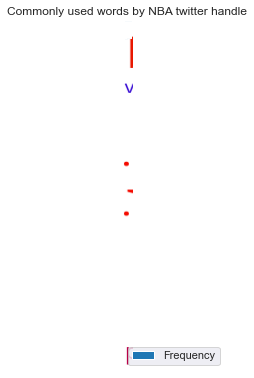

<Figure size 720x720 with 0 Axes>

In [8]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import nltk
from nltk import word_tokenize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

consumer_key = '1PKoOhaOjVEm9Q1DMqOG6ZogL'
consumer_secret = 'PxOOHEWBeGn8Wh7BSRzNXIY9uQfyqPAJdkf4qYAtPffzl7WFC2'

access_token = '1128840976875839488-9EHVtaEVx7Le7hS4jpvsPg2XETnG0R'
access_token_secret = 'Q3JSXlJiBXAZPm4Vi18eAUK5j770pwbLafZF0784tkrNh'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)

public_tweets = api.search('COVID', count=1000, lang = "en", tweet_mode="extended")

df = pd.DataFrame( [tweet.full_text for tweet in public_tweets], columns=['Tweets'])

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed mentions
    text = re.sub(r'#', '', text) #Removed hashtags
    text = re.sub(r'RT[\s]+', '', text) #Remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlink
    text = re.sub(r':[\s]+', '', text) #Remove columns
    text = re.sub(r'\'[\s]+', '', text) #Remove apostrophe
    text = re.sub(r'\...+', '', text) #Remove dots
    
    return text

#Cleaning the text
df['Tweets'] = df['Tweets'].apply(clean_text)

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['Tweets'].apply(get_subjectivity)
df['Polarity'] = df['Tweets'].apply(get_polarity)

nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sid = SIA()
results = []

def get_sentiment(row, **kwargs):
    sentiment_score = sid.polarity_scores(row)
    positive_meter = round((sentiment_score['pos'] * 10), 2)
    negative_meter = round((sentiment_score['neg'] * 10), 2) 
    return positive_meter if kwargs['k'] == 'positive' else negative_meter

df['positive'] = df.Tweets.apply(get_sentiment, k='positive')
df['negative'] = df.Tweets.apply(get_sentiment, k='negative')
df['neutral'] = df.Tweets.apply(get_sentiment, k='neutral')
df['compound'] = df.Tweets.apply(get_sentiment, k='compound')

df['label'] = 0
df.loc[df['positive'] > 0.2, 'label'] = 1
df.loc[df['negative'] > 0.2, 'label'] = -1


#Plotting a bar chart

sns.set(rc={'figure.figsize':(8,6)})

counts = df.label.value_counts(normalize=True) * 100

ax = sns.barplot(x=counts.index, y=counts)
ax.set(title="Plot of Percentage Sentiment");
ax.set_xticklabels(['Negative', 'Neutral', 'Positive']);
ax.set_ylabel("Percentage");

stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
words = (df.Tweets
           .str.lower()
           .replace([r'\|',r'\&',r'\-',r'\.',r'\,',r'\'', RE_stopwords], [' ', '','','','','',''], regex=True)
           .str.cat(sep=' ')
           .split()
)


from collections import Counter

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')
#rslt

rslt_wordcloud = pd.DataFrame(Counter(words).most_common(100),
                    columns=['Word', 'Frequency'])
#BAR CHART
rslt.plot.bar(rot=40, figsize=(10,6), width=0.8,colormap='tab10')
plt.title("Commonly used words by NBA twitter handle")
plt.ylabel("Count")

from pylab import rcParams
rcParams['figure.figsize'] = 8,6

#Wordcloud from generated words without stopwords

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

wordcloud = WordCloud(max_font_size=60, max_words=100, width=480, height=380,colormap="brg",
                      background_color="white").generate(' '.join(rslt_wordcloud['Word']));
                      
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off");
plt.figure(figsize=[10,10]);
plt.show();